##Nuclei detection with Mask RCNN

In [218]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

from config import Config
import utils
import model as modellib
import visualize
import skimage.color
import skimage.io
from skimage.io import imread, imshow, imread_collection, concatenate_images
from model import log


%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

##Configuration

In [245]:
class NucleiConfig(Config):
    """Configuration for training on the nuclei dataset.
    Derives from the base Config class and overrides values specific
    to the toy nuclei dataset.
    """
    # Give the configuration a recognizable name
    NAME = "nuclei"

    # Train on 1 GPU and 2 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 2 (GPUs * images/GPU).
    # Use the highest number that the GPU/CPU can handel ?
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 nuclei class

    # Set the limits of the small side
    # the large side, and that determines the image shape.
    # Image are resized such that the smallest side is >= the min dim 
    # the longest side is <= the max dim
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Number of ROI per image to feed the classifier. The mask RCNN paper 
    # use 512 but often the RPN doesn't generate enough positive proposal
    # to fill this and keep a positive:negative ratio of 1:3.
    # The mean is about 60? choose 200 to keep the positive rate 33%
    TRAIN_ROIS_PER_IMAGE = 200

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 20

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
    # Max number of final detection, adjust according to the distribution
    DETECTION_MAX_INSTANCES = 380
    
config = NucleiConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[64 64]
 [32 32]
 [16 16]
 [ 8  8]
 [ 4  4]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        380
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  256
IMAGE_MIN_DIM                  256
IMAGE_PADDING                  True
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           nuclei
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING         2000
ROI_

## Dataset

Create a nuclei dataset



In [44]:
TRAIN_PATH = './input/stage1_train/'
TEST_PATH = './input/stage1_test/'
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [232]:
#create the nuclei dataset

class NucleiDataset(utils.Dataset):
    
    def load_nuclei(self, path, ids):       
        #Add class
        self.add_class("nuclei", 1, "nuclei")

        # Add image
        for i in range(len(ids)):
            path_image = path + ids[i] + '/images/' + ids[i] + '.png'
            mask_path = path + ids[i] + '/masks/'
            self.add_image("nuclei", image_id=i, path=path_image, maskpath=mask_path)
     
     
    def load_image(self, image_id):
        """Load the specified image and return a [H,W,3] Numpy array.
        """
        # Load image
        image = skimage.io.imread(self.image_info[image_id]['path'])[:, :, :3]
        # If grayscale. Convert to RGB for consistency.
        if image.ndim != 3:
            image = skimage.color.gray2rgb(image)
        return image       
  
         
    def load_mask(self, i):
        img = self.load_image(i)
        width = img.shape[1]
        height = img.shape[0]
        mask = np.zeros((height, width, 1), dtype=np.bool)
        for mask_file in next(os.walk(self.image_info[i]['maskpath']))[2]:            
            mask_ = imread(self.image_info[i]['maskpath'] + mask_file)
            mask[:,:,0] = np.maximum(mask[:,:,0], mask_)   
        class_ids = np.array([1])
        return mask, class_ids
        

In [246]:
#load the first 10 images
dataset_train = NucleiDataset()
dataset_train.load_nuclei(TRAIN_PATH, train_ids[0:35])
dataset_train.prepare()

# Validation dataset
dataset_val = NucleiDataset()
dataset_val.load_nuclei(TRAIN_PATH, train_ids[35:40])
dataset_val.prepare()

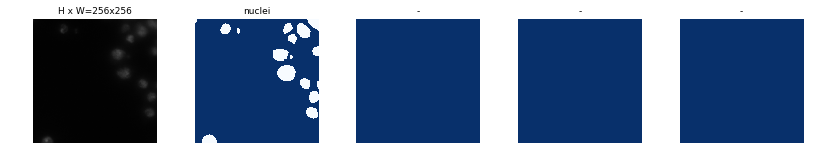

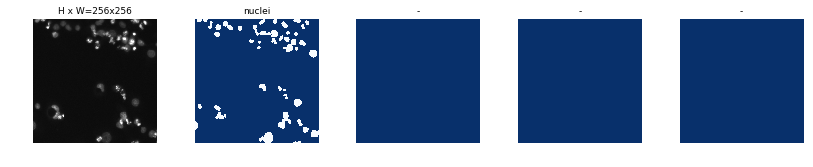

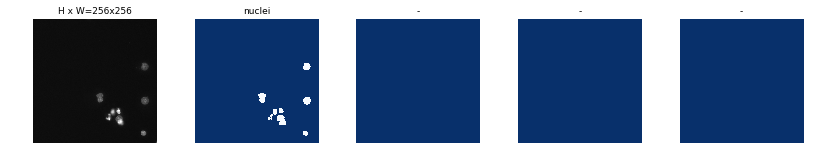

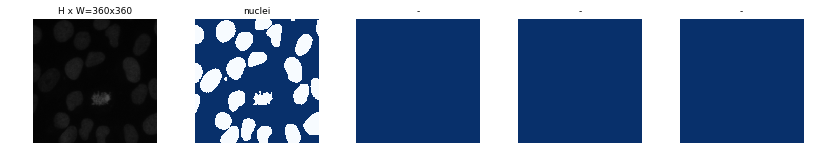

In [247]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)


##Create model

In [249]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [250]:
# Which weights to start with? Used coco weights? 
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

##Training
Train in two stages:

Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass layers='heads' to the train() function.

Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass layers="all to train all layers.

In [251]:
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /Users/yzu280/Documents/kaggle/Kaggle2018/logs/nuclei20180312T2215/mask_rcnn_nuclei_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDis

/Users/yzu280/Documents/kaggle/Kaggle2018/venv/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/Users/yzu280/Documents/kaggle/Kaggle2018/venv/lib/python3.6/site-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1


/Users/yzu280/Documents/kaggle/Kaggle2018/venv/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


/Users/yzu280/Documents/kaggle/Kaggle2018/venv/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


 1/20 [>.............................] - ETA: 7:01 - loss: 5.6312 - rpn_class_loss: 0.0737 - rpn_bbox_loss: 4.8211 - mrcnn_class_loss: 0.7364 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

 2/20 [==>...........................] - ETA: 5:38 - loss: 4.6643 - rpn_class_loss: 0.0474 - rpn_bbox_loss: 3.0792 - mrcnn_class_loss: 0.5302 - mrcnn_bbox_loss: 0.4999 - mrcnn_mask_loss: 0.5078        

 3/20 [===>..........................] - ETA: 4:51 - loss: 5.3359 - rpn_class_loss: 0.0421 - rpn_bbox_loss: 3.4970 - mrcnn_class_loss: 0.3809 - mrcnn_bbox_loss: 0.7114 - mrcnn_mask_loss: 0.7045

 4/20 [=====>........................] - ETA: 4:35 - loss: 4.7715 - rpn_class_loss: 0.0463 - rpn_bbox_loss: 2.8732 - mrcnn_class_loss: 0.3001 - mrcnn_bbox_loss: 0.8124 - mrcnn_mask_loss: 0.7394

 5/20 [======>.......................] - ETA: 4:22 - loss: 4.9977 - rpn_class_loss: 0.0419 - rpn_bbox_loss: 3.1103 - mrcnn_class_loss: 0.2483 - mrcnn_bbox_loss: 0.8163 - mrcnn_mask_loss: 0.7808

 6/20 [========>.....................] - ETA: 4:08 - loss: 5.1089 - rpn_class_loss: 0.0407 - rpn_bbox_loss: 3.0645 - mrcnn_class_loss: 0.2143 - mrcnn_bbox_loss: 0.9131 - mrcnn_mask_loss: 0.8763

 7/20 [=========>....................] - ETA: 3:51 - loss: 5.1421 - rpn_class_loss: 0.0385 - rpn_bbox_loss: 3.1334 - mrcnn_class_loss: 0.1908 - mrcnn_bbox_loss: 0.9003 - mrcnn_mask_loss: 0.8790

 8/20 [===========>..................] - ETA: 3:36 - loss: 4.9334 - rpn_class_loss: 0.0375 - rpn_bbox_loss: 3.0337 - mrcnn_class_loss: 0.1762 - mrcnn_bbox_loss: 0.8909 - mrcnn_mask_loss: 0.7951

 9/20 [============>.................] - ETA: 3:16 - loss: 4.8914 - rpn_class_loss: 0.0395 - rpn_bbox_loss: 2.9489 - mrcnn_class_loss: 0.1589 - mrcnn_bbox_loss: 0.8727 - mrcnn_mask_loss: 0.8713

10/20 [==============>...............] - ETA: 2:57 - loss: 4.6449 - rpn_class_loss: 0.0377 - rpn_bbox_loss: 2.7841 - mrcnn_class_loss: 0.1451 - mrcnn_bbox_loss: 0.8837 - mrcnn_mask_loss: 0.7944

11/20 [===============>..............] - ETA: 2:38 - loss: 4.6831 - rpn_class_loss: 0.0393 - rpn_bbox_loss: 2.7245 - mrcnn_class_loss: 0.1347 - mrcnn_bbox_loss: 0.8772 - mrcnn_mask_loss: 0.9074

12/20 [=================>............] - ETA: 2:19 - loss: 4.9295 - rpn_class_loss: 0.0428 - rpn_bbox_loss: 3.1274 - mrcnn_class_loss: 0.1235 - mrcnn_bbox_loss: 0.8041 - mrcnn_mask_loss: 0.8317

13/20 [==================>...........] - ETA: 2:02 - loss: 4.7190 - rpn_class_loss: 0.0423 - rpn_bbox_loss: 2.9902 - mrcnn_class_loss: 0.1179 - mrcnn_bbox_loss: 0.7945 - mrcnn_mask_loss: 0.7740

14/20 [====================>.........] - ETA: 1:44 - loss: 4.6899 - rpn_class_loss: 0.0440 - rpn_bbox_loss: 2.9419 - mrcnn_class_loss: 0.1127 - mrcnn_bbox_loss: 0.8116 - mrcnn_mask_loss: 0.7799

15/20 [=====================>........] - ETA: 1:27 - loss: 4.4939 - rpn_class_loss: 0.0435 - rpn_bbox_loss: 2.7962 - mrcnn_class_loss: 0.1072 - mrcnn_bbox_loss: 0.8000 - mrcnn_mask_loss: 0.7470

16/20 [=======================>......] - ETA: 1:09 - loss: 4.3947 - rpn_class_loss: 0.0440 - rpn_bbox_loss: 2.7375 - mrcnn_class_loss: 0.1056 - mrcnn_bbox_loss: 0.7945 - mrcnn_mask_loss: 0.7130

17/20 [========================>.....] - ETA: 52s - loss: 4.2756 - rpn_class_loss: 0.0430 - rpn_bbox_loss: 2.6405 - mrcnn_class_loss: 0.1006 - mrcnn_bbox_loss: 0.7765 - mrcnn_mask_loss: 0.7150 

18/20 [==========================>...] - ETA: 35s - loss: 4.2646 - rpn_class_loss: 0.0443 - rpn_bbox_loss: 2.6255 - mrcnn_class_loss: 0.0982 - mrcnn_bbox_loss: 0.7676 - mrcnn_mask_loss: 0.7291

19/20 [===========================>..] - ETA: 17s - loss: 4.2084 - rpn_class_loss: 0.0452 - rpn_bbox_loss: 2.5952 - mrcnn_class_loss: 0.0950 - mrcnn_bbox_loss: 0.7521 - mrcnn_mask_loss: 0.7209

20/20 [==============================] - 359s 18s/step - loss: 4.1034 - rpn_class_loss: 0.0446 - rpn_bbox_loss: 2.5023 - mrcnn_class_loss: 0.0924 - mrcnn_bbox_loss: 0.7477 - mrcnn_mask_loss: 0.7164 - val_loss: 2.9387 - val_rpn_class_loss: 0.0170 - val_rpn_bbox_loss: 1.6559 - val_mrcnn_class_loss: 0.0162 - val_mrcnn_bbox_loss: 0.8765 - val_mrcnn_mask_loss: 0.3731


In [252]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")


Starting at epoch 1. LR=0.0001

Checkpoint Path: /Users/yzu280/Documents/kaggle/Kaggle2018/logs/nuclei20180312T2215/mask_rcnn_nuclei_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b       

/Users/yzu280/Documents/kaggle/Kaggle2018/venv/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/Users/yzu280/Documents/kaggle/Kaggle2018/venv/lib/python3.6/site-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 2/2


/Users/yzu280/Documents/kaggle/Kaggle2018/venv/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


/Users/yzu280/Documents/kaggle/Kaggle2018/venv/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


 1/20 [>.............................] - ETA: 12:08 - loss: 4.6391 - rpn_class_loss: 0.0328 - rpn_bbox_loss: 3.8911 - mrcnn_class_loss: 0.0412 - mrcnn_bbox_loss: 0.4194 - mrcnn_mask_loss: 0.2546

 2/20 [==>...........................] - ETA: 8:18 - loss: 3.1736 - rpn_class_loss: 0.0402 - rpn_bbox_loss: 2.2671 - mrcnn_class_loss: 0.0309 - mrcnn_bbox_loss: 0.5856 - mrcnn_mask_loss: 0.2497 

 3/20 [===>..........................] - ETA: 6:37 - loss: 2.7339 - rpn_class_loss: 0.0422 - rpn_bbox_loss: 1.7059 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.5784 - mrcnn_mask_loss: 0.3853

 4/20 [=====>........................] - ETA: 5:39 - loss: 2.4707 - rpn_class_loss: 0.0425 - rpn_bbox_loss: 1.3889 - mrcnn_class_loss: 0.0191 - mrcnn_bbox_loss: 0.6381 - mrcnn_mask_loss: 0.3821

 5/20 [======>.......................] - ETA: 5:00 - loss: 2.4340 - rpn_class_loss: 0.0438 - rpn_bbox_loss: 1.2853 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.6381 - mrcnn_mask_loss: 0.4495

 6/20 [========>.....................] - ETA: 4:37 - loss: 2.3651 - rpn_class_loss: 0.0456 - rpn_bbox_loss: 1.2537 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.5924 - mrcnn_mask_loss: 0.4557

 7/20 [=========>....................] - ETA: 4:13 - loss: 2.3147 - rpn_class_loss: 0.0450 - rpn_bbox_loss: 1.1478 - mrcnn_class_loss: 0.0178 - mrcnn_bbox_loss: 0.5982 - mrcnn_mask_loss: 0.5060

 8/20 [===========>..................] - ETA: 3:49 - loss: 2.2515 - rpn_class_loss: 0.0459 - rpn_bbox_loss: 1.1254 - mrcnn_class_loss: 0.0246 - mrcnn_bbox_loss: 0.5927 - mrcnn_mask_loss: 0.4629

 9/20 [============>.................] - ETA: 3:25 - loss: 2.1877 - rpn_class_loss: 0.0459 - rpn_bbox_loss: 1.0684 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.6049 - mrcnn_mask_loss: 0.4457

10/20 [==============>...............] - ETA: 3:03 - loss: 2.2219 - rpn_class_loss: 0.0428 - rpn_bbox_loss: 1.1511 - mrcnn_class_loss: 0.0206 - mrcnn_bbox_loss: 0.5844 - mrcnn_mask_loss: 0.4230

11/20 [===============>..............] - ETA: 2:43 - loss: 2.3291 - rpn_class_loss: 0.0418 - rpn_bbox_loss: 1.2349 - mrcnn_class_loss: 0.0210 - mrcnn_bbox_loss: 0.6224 - mrcnn_mask_loss: 0.4090

12/20 [=================>............] - ETA: 2:23 - loss: 2.3534 - rpn_class_loss: 0.0389 - rpn_bbox_loss: 1.2600 - mrcnn_class_loss: 0.0241 - mrcnn_bbox_loss: 0.6254 - mrcnn_mask_loss: 0.4050

13/20 [==================>...........] - ETA: 2:04 - loss: 2.2791 - rpn_class_loss: 0.0397 - rpn_bbox_loss: 1.2067 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.5982 - mrcnn_mask_loss: 0.4110

14/20 [====================>.........] - ETA: 1:46 - loss: 2.2537 - rpn_class_loss: 0.0384 - rpn_bbox_loss: 1.1641 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.5988 - mrcnn_mask_loss: 0.4286

15/20 [=====================>........] - ETA: 1:28 - loss: 2.1639 - rpn_class_loss: 0.0387 - rpn_bbox_loss: 1.0963 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.5909 - mrcnn_mask_loss: 0.4155

16/20 [=======================>......] - ETA: 1:10 - loss: 2.1249 - rpn_class_loss: 0.0387 - rpn_bbox_loss: 1.0734 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.5845 - mrcnn_mask_loss: 0.4051

17/20 [========================>.....] - ETA: 52s - loss: 2.0540 - rpn_class_loss: 0.0375 - rpn_bbox_loss: 1.0287 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.5747 - mrcnn_mask_loss: 0.3907 

18/20 [==========================>...] - ETA: 34s - loss: 2.0360 - rpn_class_loss: 0.0359 - rpn_bbox_loss: 1.0226 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.5751 - mrcnn_mask_loss: 0.3795

19/20 [===========================>..] - ETA: 17s - loss: 2.0025 - rpn_class_loss: 0.0363 - rpn_bbox_loss: 0.9954 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.5608 - mrcnn_mask_loss: 0.3881

20/20 [==============================] - 357s 18s/step - loss: 1.9503 - rpn_class_loss: 0.0364 - rpn_bbox_loss: 0.9662 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.5477 - mrcnn_mask_loss: 0.3786 - val_loss: 2.7386 - val_rpn_class_loss: 0.0524 - val_rpn_bbox_loss: 1.8736 - val_mrcnn_class_loss: 0.0449 - val_mrcnn_bbox_loss: 0.5796 - val_mrcnn_mask_loss: 0.1881


In [253]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes_0312.h5")
model.keras_model.save_weights(model_path)

##Detection

In [255]:
class InferenceConfig(NucleiConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /Users/yzu280/Documents/kaggle/Kaggle2018/logs/nuclei20180312T2215/mask_rcnn_nuclei_0002.h5


original_image           shape: (256, 256, 3)         min:    2.00000  max:   37.00000
image_meta               shape: (10,)                 min:    0.00000  max:  360.00000
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000
gt_bbox                  shape: (1, 4)                min:    0.00000  max:  256.00000
gt_mask                  shape: (256, 256, 1)         min:    0.00000  max:    1.00000


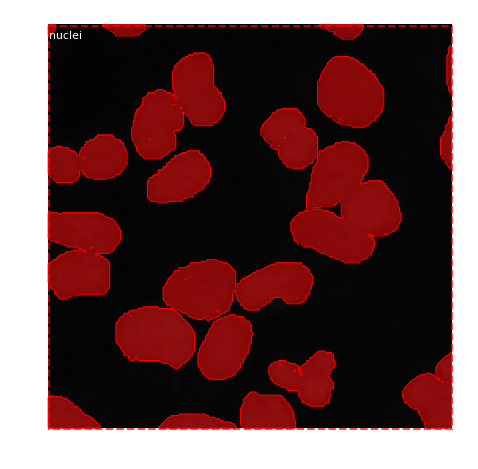

In [269]:
# Test on a random image
image_id = random.choice(dataset_train.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_train, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

In [266]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:   37.00000
molded_images            shape: (1, 256, 256, 3)      min: -121.70000  max:  -66.90000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000


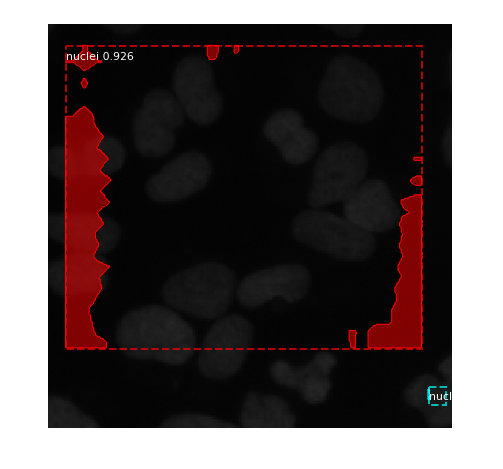

In [270]:
results = model.detect([original_image], verbose=1)

r = results[0]
#print(r)
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())